# Exercise 08 RNN & NLP - Instruction

## Pedagogy

This notebook serves as an instruction for implementing RNNs using PyTorch for NLP tasks.

Please use this notebook as a reference and guide to complete the assignment.

### Pre-configure

In this notebook, we will use the following new libraries:
- `nltk`: the Natural Language Toolkit that provides most of the basic tools you need for NLP

Please install the new libraries before using them.

In [1]:
!pip install nltk

In [2]:
# import libraries
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter

In [3]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [4]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Instruction

In this notebook, we will build a text classification model using RNN, more specifically, LSTM.

The problem to be solved is to classify different news into one of the 4 pre-defined classes:

|Class|Example news|
|-|-|
|World|France marks the 'other D-Day' Two days of celebrations to honour the Allied veterans who liberated southern France near a climax...|
|Sports|Galaxy, Crew Play to 0-0 Tie (AP) AP - Kevin Hartman made seven saves for Los Angeles, and Jon Busch had two saves for Columbus as the Galaxy and Crew played to a 0-0 tie Saturday night...|
|Business|Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again...|
|Sci/Tech|Apple to open second Japanese retail store this month (MacCentral) MacCentral - Apple Computer Inc. will open its second Japanese retail store later this month in the western Japanese city of Osaka, it said Thursday...|

In [5]:
classes = ['World', 'Sports', 'Business', 'Sci/Tec']

### Step 1. Build the data pipeline

We will use the [AG News Dataset](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) which is a collection of news articles.

Each news article is classified into one of the 4 pre-defined classes: world, sports, business, and sci/tech.

In this step, we need to:
- Load the dataset from the `ag_news_dataset.csv` file
- Pre-process the text
    - Tokenization
    - Remove stop words (like 'and', 'the') that don't provide useful information
    - Remove non-alphabetic tokens (optional)
- Create the vocabulary
- Encode the tokens
- Create the Dataset and the Dataloader
    - Pad the tensors with variable lengths to equal length

#### Step 1.1 Load the dataset

You can download the `ag_news_dataset.csv` file from the Learn platform.

If you are using Google Colab, you need to upload this file to Colab manually.

In [6]:
# load dataset
df = pd.read_csv('ag_news_dataset.csv')
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


#### Step 1.2 Pre-process the text

- Tokenization
- Remove stop words
- Remove non-alphabetic tokens (optional)

In [7]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# apply preprocessing to the 'text' column
df['tokens'] = df['text'].apply(preprocess_text)

# show the first five rows
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/germanesteban/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/germanesteban/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/germanesteban/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,label,tokens
0,Wall St. Bears Claw Back Into the Black (Reute...,2,"[wall, bears, claw, back, black, reuters, reut..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,"[carlyle, looks, toward, commercial, aerospace..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,"[oil, economy, cloud, stocks, outlook, reuters..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,"[iraq, halts, oil, exports, main, southern, pi..."
4,"Oil prices soar to all-time record, posing new...",2,"[oil, prices, soar, record, posing, new, menac..."


#### Step 1.3 Create the vocabulary

We first count the frequency of all unique tokens in the dataset.

Then we select 20,000 most common tokens and put them into the vocabulary.

You can increase the vocabulary size by including more unique tokens.

Simply adding all unique tokens to the vocabulary is not recommended because you lose control over the size of the vocabulary.

We also add two special tokens to the vocabulary:
- `<PAD>`:
    - Represent the padding tokens added at the end of the original sequence
    - It's common to pad sequences of different lengths to the same length.
- `<UNK>`:
    - Represent the unknown tokens
    - It might be the less frequent token that is not included in the vocabulary
    - Or the unknown token from the unseen data

In [8]:
# build vocabulary
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

# keep the most common token
vocab_size = 20000
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve two spots for PAD and UNK tokens
print('The number of most common tokens preserved:', vocab_size)

# create token to index mapping
token_to_idx = {token: idx+2 for idx, (token, _) in enumerate(common_tokens)}
# '<PAD>' is used to represent padding tokens at the end of text
token_to_idx['<PAD>'] = 0
# '<UNK>' is used to represent unknown tokens that are not included in the vocabulary
token_to_idx['<UNK>'] = 1

# create index to token mapping
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

The number of unique tokens in the vocabulary: 61165
The number of most common tokens preserved: 20000


#### Step 1.4 Encode the tokens

- Convert a sequence of tokens to a sequence of numbers
- Each unique token is assigned with a unique number

In [9]:
# define a function for encoding
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx['<UNK>']) for token in tokens]

# apply the encoding function to the 'tokens' column
df['encoded_tokens'] = df['tokens'].apply(encode_tokens)

# show the first 5 rows
df.head()

,text,label,tokens,encoded_tokens
0,Wall St. Bears Claw Back Into the Black (Reute...,2,"[wall, bears, claw, back, black, reuters, reut...","[313, 1399, 13796, 52, 705, 4, 4, 313, 264, 36..."
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,"[carlyle, looks, toward, commercial, aerospace...","[14689, 908, 692, 1120, 3954, 4, 4, 759, 643, ..."
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,"[oil, economy, cloud, stocks, outlook, reuters...","[17, 245, 4140, 84, 594, 4, 4, 2153, 335, 35, ..."
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,"[iraq, halts, oil, exports, main, southern, pi...","[22, 6703, 17, 1550, 749, 402, 2545, 4, 4, 677..."
4,"Oil prices soar to all-time record, posing new...",2,"[oil, prices, soar, record, posing, new, menac...","[17, 35, 3955, 75, 6983, 2, 11416, 8, 245, 45,..."


#### Step 1.5 Create `Dataset` and `DataLoader`

Now the text is converted to a sequence of encoded tokens.

The resulting sequences from different texts can have different lengths.

We cannot directly convert a list of sequences of variable length into a `tensor` using the `TensorDataset()` API.

Instead, we need to define a custom `Dataset` class to store the data as tensors.

In [10]:
# define a custom Dataset class to store the data as tensors
class AGNewsDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return X, y

In [11]:
# create the training, test and validation dataset
ds = AGNewsDataset(df['encoded_tokens'].values, df['label'].values)
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

After that, when we create the `DataLoader` object, we can specify a collate function for the following purposes:
- The sequences in the batch have different lengths. We use the `collate_batch` function to pad all sequences to the same length
- We want to preserve the information about the length of the original sequence before padding. So we use the `collate_batch` function to record this information.

In [12]:
# define a collate function to pad the sequences in the same batch to equal length
# in addition to the padded_X and y, also return the length of X before padding
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []
    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.tensor(batch_y, dtype=torch.int64)
    # pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first = True)
    return batch_X, batch_y, batch_length

In [13]:
# create the training, validation, and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)

By applying this `collate_batch` function to each batch, we have three components per batch instead of two:
- A batch of `padded_X`:
    - A batch of sequences of encoded tokens padded to the same length
- A batch of `y`:
    - A batch of labels
- A batch of `length`:
    - A batch of lengths of the original sequences before padding

In [14]:
# get one batch and print its shape
for batch in test_dl:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2].shape)
    break

torch.Size([512, 61])
torch.Size([512])
torch.Size([512])


### Step 2. Create the LSTM-based text classifier

For text classification task, the input is a sequence of tokens, the output is a class. So we need to use the many-to-one architecture of RNN, as shown in the following figure:

![](https://i.imgur.com/C5Pgwyn.jpeg)

In this step, we need to:
- Define a custom class for the text classifier
    - Specify the network structure
        - The first layer is `nn.Embedding()`
        - There is recurrent processes, so we can't use `nn.Sequential()` container anymore
    - Specify the forward method
        - Without using `nn.Sequential()`, we need to specify the forward process step by step
            1. Word embedding
            2. Pack the batch of padded sequences for sequential processing
            3. Sequential processing with LSTM layer
            4. Make prediction using the final hidden state
- Create an instance of the network and move it to GPU 

In [15]:
# define a custom neural network class
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, (h, c) = self.lstm(packed_x)
        return self.fc(h[-1])

We need to specify the following parameters to determine the network structure:
- `vocab_size` is the number of unique tokens to embed, the size of the vocabulary
- `embed_size` is the number of embedded features to represent the tokens
- `hidden_size` is the number of hidden features of LSTM
- `num_class` is the number of classes in the dataset

In the `forward()` method, we can see the forward process has four steps:
1. `x = self.embedding(x)` performs word embedding
    - Take a batch of sequences of encoded tokens
    - Convert the sequence of encoded tokens to the sequence of embedded tokens
    - Each embedded token is represented by multiple embeded features
2. `packed_x = pack_padded_sequence(x, lengths ...)` packs the batch of padded sequences for sequential processing
   - We provide the information of the length of the original sequence before padding
   - This lets the network know when the sequence ends and ignore the remaining padding tokens.
   - Understanding the purpose of this operation is enough.
   - The actual implementation can be complex. If you are interested, you can follow a informative discussion on stack overflow from this [link](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch).
4. `out, (h, c) = self.lstm(packed_x)` use the LSTM layer to process the sequence of embedded tokens
    - `out` is the sequence of all hidden state at each timestep
    - `h` is the final hidden state
    - `c` is the final cell state
5. `return self.fc(h[-1])` make prediction using the final hidden state and a FC layer
    - The shape of `h` is (1, batch_size, hidden_size)
    - `h[-1]` delete the first useless dimension, the shape of `h[-1]` is (batch_size, hidden_size)
    - The returned values are logits since we have a multi-class classification problem

In [16]:
# create the neural network
embed_size = 64
hidden_size = 32
num_class = 4
model = LSTMClassifier(vocab_size, embed_size, hidden_size, num_class)
model = model.to(device)

### Step 3. Train the network

The code is the same as the previous sessions. We need to:
- Define a `train()` function to perform the training process
- Specify the training hyper-parameters
- Implement the training process
- Visualize the loss history

In [17]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [18]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)
saved_path_prefix = 'ag_news_classifier'

In [19]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|██████████| 35/35 [00:01<00:00, 28.91it/s]


Epoch 1: train loss = 1.386079, val loss = 1.379796, time consumed = 0:00:46
Model saved after epoch 1



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 32.17it/s]


Epoch 2: train loss = 1.374377, val loss = 1.369221, time consumed = 0:01:18
Model saved after epoch 2



Validation batch: 100%|██████████| 35/35 [00:00<00:00, 35.23it/s]


Epoch 3: train loss = 1.362925, val loss = 1.357936, time consumed = 0:01:50
Model saved after epoch 3



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.69it/s]


Epoch 4: train loss = 1.349467, val loss = 1.343544, time consumed = 0:02:23
Model saved after epoch 4



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.27it/s]


Epoch 5: train loss = 1.332273, val loss = 1.325275, time consumed = 0:02:55
Model saved after epoch 5



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.04it/s]


Epoch 6: train loss = 1.309523, val loss = 1.300395, time consumed = 0:03:27
Model saved after epoch 6



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.58it/s]


Epoch 7: train loss = 1.273521, val loss = 1.252114, time consumed = 0:03:59
Model saved after epoch 7



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.42it/s]


Epoch 8: train loss = 1.189965, val loss = 1.146528, time consumed = 0:04:30
Model saved after epoch 8



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.22it/s]


Epoch 9: train loss = 1.094132, val loss = 1.060579, time consumed = 0:05:02
Model saved after epoch 9



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.27it/s]


Epoch 10: train loss = 1.022372, val loss = 0.968861, time consumed = 0:05:34
Model saved after epoch 10



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.92it/s]


Epoch 11: train loss = 0.942979, val loss = 0.911890, time consumed = 0:06:06
Model saved after epoch 11



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.12it/s]


Epoch 12: train loss = 0.844461, val loss = 0.820700, time consumed = 0:06:39
Model saved after epoch 12



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 32.00it/s]


Epoch 13: train loss = 0.772237, val loss = 0.812158, time consumed = 0:07:12
Model saved after epoch 13



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.96it/s]


Epoch 14: train loss = 0.719617, val loss = 0.750024, time consumed = 0:07:46
Model saved after epoch 14



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.46it/s]


Epoch 15: train loss = 0.675276, val loss = 0.687756, time consumed = 0:08:17
Model saved after epoch 15



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 27.67it/s]


Epoch 16: train loss = 0.632365, val loss = 0.635950, time consumed = 0:08:49
Model saved after epoch 16



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.27it/s]


Epoch 17: train loss = 0.593841, val loss = 0.670181, time consumed = 0:09:21


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.06it/s]


Epoch 18: train loss = 0.570647, val loss = 0.587364, time consumed = 0:09:53
Model saved after epoch 18



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.61it/s]


Epoch 19: train loss = 0.549044, val loss = 0.600315, time consumed = 0:10:25


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.42it/s]


Epoch 20: train loss = 0.527171, val loss = 0.577386, time consumed = 0:10:57
Model saved after epoch 20



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.92it/s]


Epoch 21: train loss = 0.511523, val loss = 0.543527, time consumed = 0:11:29
Model saved after epoch 21



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.49it/s]


Epoch 22: train loss = 0.492972, val loss = 0.527264, time consumed = 0:12:01
Model saved after epoch 22



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.14it/s]


Epoch 23: train loss = 0.481295, val loss = 0.521947, time consumed = 0:12:32
Model saved after epoch 23



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.71it/s]


Epoch 24: train loss = 0.463374, val loss = 0.512592, time consumed = 0:13:04
Model saved after epoch 24



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.42it/s]


Epoch 25: train loss = 0.457538, val loss = 0.576156, time consumed = 0:13:35


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.07it/s]


Epoch 26: train loss = 0.449559, val loss = 0.562397, time consumed = 0:14:06


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.70it/s]


Epoch 27: train loss = 0.438788, val loss = 0.494297, time consumed = 0:14:38
Model saved after epoch 27



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.34it/s]


Epoch 28: train loss = 0.430823, val loss = 0.510827, time consumed = 0:15:09


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.90it/s]


Epoch 29: train loss = 0.421999, val loss = 0.493132, time consumed = 0:15:40
Model saved after epoch 29



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.50it/s]


Epoch 30: train loss = 0.414124, val loss = 0.536634, time consumed = 0:16:12


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.05it/s]


Epoch 31: train loss = 0.410677, val loss = 0.493186, time consumed = 0:16:43


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.07it/s]


Epoch 32: train loss = 0.402038, val loss = 0.476701, time consumed = 0:17:14
Model saved after epoch 32



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.71it/s]


Epoch 33: train loss = 0.397320, val loss = 0.475170, time consumed = 0:17:46
Model saved after epoch 33



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.40it/s]


Epoch 34: train loss = 0.391437, val loss = 0.475287, time consumed = 0:18:17


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.55it/s]


Epoch 35: train loss = 0.387724, val loss = 0.468569, time consumed = 0:18:48
Model saved after epoch 35



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.96it/s]


Epoch 36: train loss = 0.383133, val loss = 0.482220, time consumed = 0:19:19


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.72it/s]


Epoch 37: train loss = 0.379645, val loss = 0.467662, time consumed = 0:19:51
Model saved after epoch 37



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.88it/s]


Epoch 38: train loss = 0.373533, val loss = 0.463850, time consumed = 0:20:23
Model saved after epoch 38



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.33it/s]


Epoch 39: train loss = 0.371287, val loss = 0.460902, time consumed = 0:20:54
Model saved after epoch 39



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.46it/s]


Epoch 40: train loss = 0.367770, val loss = 0.458046, time consumed = 0:21:25
Model saved after epoch 40



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.25it/s]


Epoch 41: train loss = 0.361076, val loss = 0.467955, time consumed = 0:21:57


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.93it/s]


Epoch 42: train loss = 0.358464, val loss = 0.459165, time consumed = 0:22:28


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.54it/s]


Epoch 43: train loss = 0.354262, val loss = 0.465292, time consumed = 0:22:59


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.17it/s]


Epoch 44: train loss = 0.353115, val loss = 0.455170, time consumed = 0:23:30
Model saved after epoch 44



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.26it/s]


Epoch 45: train loss = 0.349602, val loss = 0.456829, time consumed = 0:24:01


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.54it/s]


Epoch 46: train loss = 0.345510, val loss = 0.478557, time consumed = 0:24:33


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 26.39it/s]


Epoch 47: train loss = 0.344796, val loss = 0.459409, time consumed = 0:25:04


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.44it/s]


Epoch 48: train loss = 0.339920, val loss = 0.468977, time consumed = 0:25:35


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 24.73it/s]


Epoch 49: train loss = 0.338643, val loss = 0.448482, time consumed = 0:26:08
Model saved after epoch 49



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.43it/s]


Epoch 50: train loss = 0.334618, val loss = 0.446437, time consumed = 0:26:40
Model saved after epoch 50



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 32.77it/s]


Epoch 51: train loss = 0.332210, val loss = 0.454685, time consumed = 0:27:11


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.56it/s]


Epoch 52: train loss = 0.331166, val loss = 0.456965, time consumed = 0:27:42


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.44it/s]


Epoch 53: train loss = 0.327671, val loss = 0.454071, time consumed = 0:28:14


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 34.11it/s]


Epoch 54: train loss = 0.325300, val loss = 0.446737, time consumed = 0:28:45


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.54it/s]


Epoch 55: train loss = 0.323042, val loss = 0.452765, time consumed = 0:29:16


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.92it/s]


Epoch 56: train loss = 0.321604, val loss = 0.453457, time consumed = 0:29:48
Learning rate reduced after epoch 56



Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.91it/s]


Epoch 57: train loss = 0.306704, val loss = 0.448546, time consumed = 0:30:20


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 31.15it/s]


Epoch 58: train loss = 0.305510, val loss = 0.448368, time consumed = 0:30:52


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.43it/s]


Epoch 59: train loss = 0.304713, val loss = 0.448183, time consumed = 0:31:24


Validation batch: 100%|██████████| 35/35 [00:01<00:00, 33.59it/s]

Epoch 60: train loss = 0.304344, val loss = 0.448740, time consumed = 0:31:55
Early stopping!


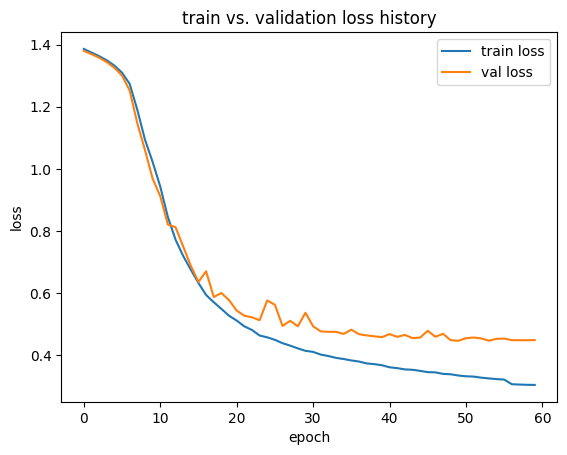

In [20]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Step 4. Reload the best model

The final model after training may mot be the best one saved during the training process.

To use the best model, we need to reload it from the saved file.

In [21]:
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

LSTMClassifier(
  (embedding): Embedding(20000, 64)
  (lstm): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

### Step 5. Evaluation using test set

The code is the same as the previous sessions. We need to:
- Define a `test()` function to make predictions on the test set
- Compute the classification report for evaluation

In [22]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y, lens) in dataloader:
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            batch_logits = model(X, lens)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [23]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)

# obtain test labels
test_label = []
for (_, y, _) in test_dl:
    test_label.extend(y.cpu().numpy())

print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.4492099642753601
              precision    recall  f1-score   support

       World       0.89      0.82      0.85      9636
      Sports       0.89      0.94      0.91      9598
    Business       0.83      0.80      0.81      9574
     Sci/Tec       0.79      0.83      0.81      9472

    accuracy                           0.85     38280
   macro avg       0.85      0.85      0.85     38280
weighted avg       0.85      0.85      0.85     38280



### Step 6. Make predictions on unseen data

We can use the trained model to classify unseen news into one of the pre-defined classes.

To do that, we can define a `predict_text()` function:
- Take a list of text as inputs
- Perform necessary pre-processing steps
    - Tokenization
    - Encode tokens
    - Pad the sequence of encode tokens
- Feed the text to the network in batch and get predictions

In [24]:
# define a function to predict the classes of a list of text
def predict_text(model, text_list):
    X, lens = [], []
    for text in text_list:
        tokens = preprocess_text(text)
        encoded_tokens = encode_tokens(tokens)
        X.append(torch.tensor(encoded_tokens, dtype=torch.int64))
        lens.append(len(encoded_tokens))
    X = pad_sequence(X, batch_first=True)
    lens = torch.tensor(lens, dtype=torch.int64)
    with torch.no_grad():
        logits = model(X.to(device), lens.to(device))
        _, preds = torch.max(logits, 1)
    return preds.cpu().numpy()

In [25]:
# example texts
text_list = [
    "The stock market closed higher today with tech stocks leading the gains.",
    "The national team won their match and qualified for the finals.",
    "A new species of dinosaur was discovered by scientists.",
    "The prime minister met with the president to discuss trade agreements."
]
# make prediction
preds = predict_text(model, text_list)
# print results
for idx in range(len(text_list)):
    text = text_list[idx]
    pred = preds[idx]
    print(f'Text: {text}\nPredicted category: {classes[pred]}\n')

Text: The stock market closed higher today with tech stocks leading the gains.
Predicted category: Business

Text: The national team won their match and qualified for the finals.
Predicted category: Sports

Text: A new species of dinosaur was discovered by scientists.
Predicted category: Sci/Tec

Text: The prime minister met with the president to discuss trade agreements.
Predicted category: World

